### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Sparse Coding and Dictionary Learning #

#### Qinyuan Sun(qsun28@wisc.edu), Tingting Wei (twei26@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

    In this project, we will learn sparse coding and dictionary learning. In general, sparse coding is to represent some signals with as few variables as possible. This idea of parsimony can be traced back to philosopher and theologian William of Ockham. In science, Occam's razor is used as a heuristic technique to guide scientists in the development of theoretical models by prefering simpler model. 
    In statistic, modeling of physical observations usually prefer simple models with small number of learning parameters in order to provide better predictive power. Thus, they developed numerous model selection techniques. In signal processing, Observations, or data vectors, are called “signals”, and data modeling appears to be a crucial step for performing various operations such as restoration, compression, or for solving inverse problems. Each signal is approximated by a sparse linear combination of prototypes called dictionary elements, resulting in simple and compact models.
    At first, researchers and engineers designed orthonormal basis system as dictionary elements for certain type of signals. For example, dicrete fourier transform basis for sinusoidal signal and discrete wavelet basis for images. However, some signals can not be well  approximated by a sparse linear combination of a basis system. Instead of using off-the-shelf dictionaries, researchers proposed to learn the signals from training data. In their experiments, they demonstrated that dictionary learning could easily discover underlying structures in natural image patches and improve the performance of many applications in image denoising, image compression, image super-resolution and so on.
    This report is organized as follow: in Mathematical model section we will discuss sparse coding using orthonormal basis system, then we will show one case that one basis system fails to result in sparse representation. Then, we will discuss dictionary learning and formulate the problem as an optimization problem. In solution section, we will show how to solve these problems using standard solvers followed by observations and discussion in results and discussion section.

## 2. Mathematical model ##

### Basis System
In this project, we are interested in sparse coding and dictionary learning. The goal is to represent the signal in a succint way. One of the most foundamental way to represent a signal is to utilize a basis system. Here we denote a signal as a N dimension vector $X \in R^N$ and denote a basis system as $H \in R^{N \times N}$. There is one basis system we use everyday, that is the natural basis system $E$ where i-th column $e_i = [0 \ 0 \dots 1 \dots 0]^T$, where the 1 is at i-th row in the column vector. Other commonly used basis systems are Discrete Fourier Transform (DFT) basis, Discrete Wavelet Transform basis. For a paticular signal, one basis system might represent it better than other basis system. Mathematically speaking, a signal represented by a basis system can be expressed as $X = HA$, where $A = [a_1 \ a_2 \dots a_N ]^T \in R^N$ is the coefficient of the basis. By saying a signal can be represented a in succint way or sparsely, we mean we use small number of basis to represent the signal, i.e. $\| A \|_{0}$, A's $\ell_0$ norm is small. 

For example, let's look at a sinusoidal signal. According to Nyquist Frequency, a 2Hz sine wave needs to be sampled at 4Hz or higher frequency. Let $x_t = \sin (4\pi t)$ and $X = [x_1 \ x_2 \dots x_{100}]^T$. By assumption, this signal is expressed in the natural basis. We can apply and DFT and express the signal in DFT basis, which result in two non-zero coeffient on the basis represent 2Hz. As we know, DFT basis is the best basis system to represent a single frequency sine wave. 

On the other hand, if we have a spike signal $X = [1 \  0 \dots 0]^T \in R^{100}$ , the natural basis is the best basis system by using $e_1$to represent it while DFT basis needs all 100 basis elements. 


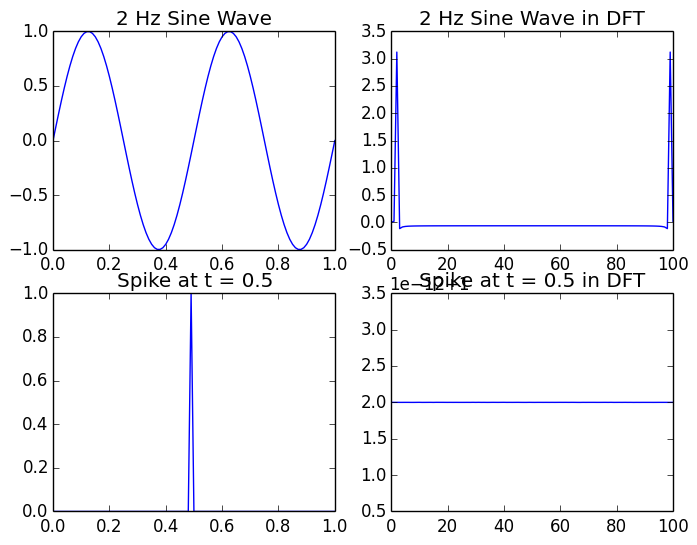

PyObject <matplotlib.text.Text object at 0x315afc510>

In [10]:
t = 0:0.01:1;
X = sin(4pi*t)
X1 = zeros(101)
X1[50] = 1
X_dft = fft(X)
using PyPlot
subplot(221)
plt1 = plot( t, X, "b" )
#xlabel("Time")
#ylabel("Signal")
title("2 Hz Sine Wave")
subplot(222)
plt2 = plot(X_dft)
title("2 Hz Sine Wave in DFT")
subplot(223)
plt3 = plot(t, X1, "b")
X1_dft = fft(X1)
title("Spike at t = 0.5")
subplot(224)
plt4 = plot(abs(X1_dft))
title("Spike at t = 0.5 in DFT") 

### Go Beyond Basis System
In general, people like to use basis systems because they have great properties. A basis system is orthornormal. Finding the coefficient vector $A$ can simply be solved by inverting a matrix. In addition, the representation will be unique. However, many signals might not have a sparse representation in any basis system. For example, if we have a signal that is a mix of spikes and sinusoidal signals, neither natural basis nor DFT basis can express the signal efficiently.

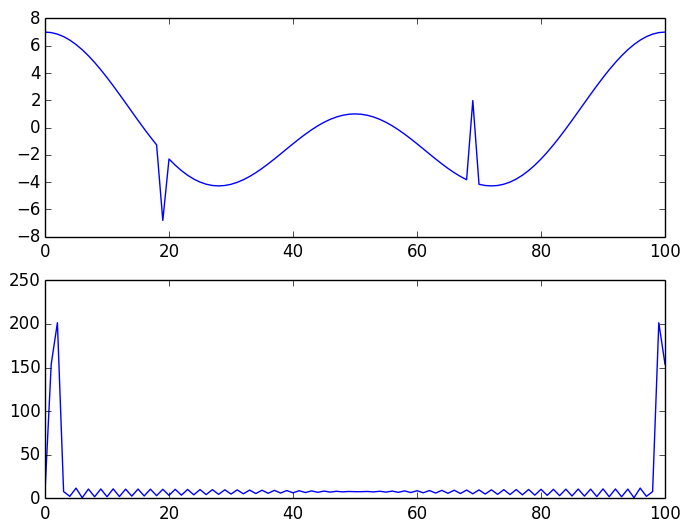

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3151dc610>

In [11]:
t = 0:1:100;
X = 3cos(2*pi*t/100) + 4cos(2*pi*t/50)
X[20] = X[20] - 5
X[70] = X[70] + 6
using PyPlot
subplot(211)
plot(t,X)
subplot(212)
DFT = (fft(X,1))
plot(abs(DFT))


Since we know the signal is a combination of spike and sinusoidal signal, we can combine the natural basis system with the DFT basis system to create a dictonary. Each element in the dictionary is referred as frame. For the above signal, by inspection, we can use two frames from natural basis and two frames from DFT basis to represent it sparsely. However, the dictionary we create is an overcomplete system, which means we lose the benefits of uniqueness. In addition, when we apply least square to solve for the coeffcient, the answer is generally not what we desired.


### Leverage Sparsity Prior
Since we use overcomplete dictionary $D$ instead of basis system $H$, we have to choose from a group viable solutions. Luckily, we can leverage the sparsity prior. In other words, if $X = DA$, we want $\| A\|_{0} <= \alpha$. A signal that satisfies $\| A\|_{0} <= \alpha$ is called $\alpha$ sparse.
A greedy method that solve this probelm is called matching pursuit. The idea is simple. From the list of frames, we choose the frame i with largest inner product $<X, D_i>$between signal and frame and set the coefficient of that frame to the inner product. Then remove the projection of $X$ on $D_i$ from $X$ and then find the next best frame base on the remainder. We stop until the remainder is 0 or $\alpha$ frames are picked.

### How to Choose Dictionary
Choosing an appropiate dictionary is crucial in sparse coding. If we know the characteristics about the signal, we can choose a dictionary based on experience. However, in most scenario, we do not know the characteristics about the signal. One method is to direct learn from the signals we want to represent. We can formulate this problem as an optimization problem $\underset{D,A}\min \|X - DA\|_2 $ subject to $\| A\|_{0} \leq \alpha$. In reality, $\ell_0$ norm constraints are hard to deal with. What people usually do is to relax it to $\ell_1$ norm constraints. $\ell_1$ norm still promotes sparsity and it is a convex constraint.

In addition, to reduce ambiguity, we also add a norm constraint on each dictionary frame: $\|D_i\|_2 \leq 1, i = 1,\dots, M$. Here, M is the number of frames in the dictionary.

Put things together we have:
$\underset{D,A}\min \|X - DA\|_2^2 + \lambda \| A \|_1$ subject to  $\|D_i\|_2^2 \leq 1, i = 1,\dots, M$


To solve this model, we can use an alternate updating procedure. If we fix $D$, the problem reduces to $\underset{A}\min \|X - DA\|_2^2 + \lambda \| A \|_1$, which is a Lasso problem.
If we fix $A$, the problem reduce to $\underset{D}\min \|X - DA\|_2^2$ subject to  $\|D_i\|_2^2 <= 1, i = 1,\dots, M$, which is a quadratic constrained quadratic programing (QCQP) problem.

## 3. Solution ##

Let's try the examples we looked at beforehand. We construct a signal as combination of two cosine waves and two spikes. In the experiments, we only use cosine wave with no phase shift for simplicity. First we examine solution of least square. The result suggests that the natural basis are used to represent some portion of cosine wave and the DFT basis are used to represent some portion of spike signals.

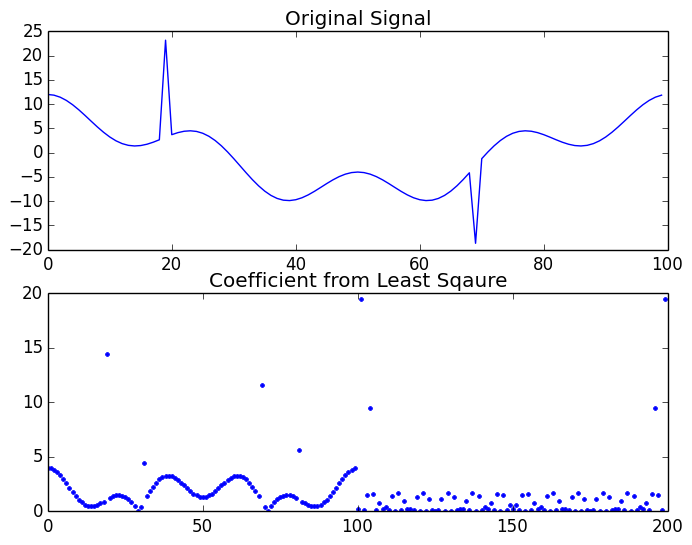

(100,200)

In [19]:
using PyPlot
#set up the signal (spike + cosine wave)
t = 0:1:99;
X = 8cos(2*pi*t/100) + 4cos(2*pi*t/25)
X[20] = X[20] + 20
X[70] = X[70] - 16
subplot(211)
plot(t,X)
title("Original Signal")
# create a dictionary based on natural basis and DFT basis
E = eye(length(t))
DFT = fft(E,1)
nDFT = DFT;
for i = 1:100
    nDFT[:,i] = real(DFT[:,i])/norm(real(DFT[:,i]))
end
D = [E nDFT]
# Least square Method
A_ls = D\X
subplot(212)
plot(abs(A_ls),".")
title("Coefficient from Least Sqaure")
N, M = size(D)



Then we apply matching pursuit to discover the best basis elements.

Frame picked: 


4x1 Array{Float64,2}:
 102.0
 105.0
  20.0
  70.0

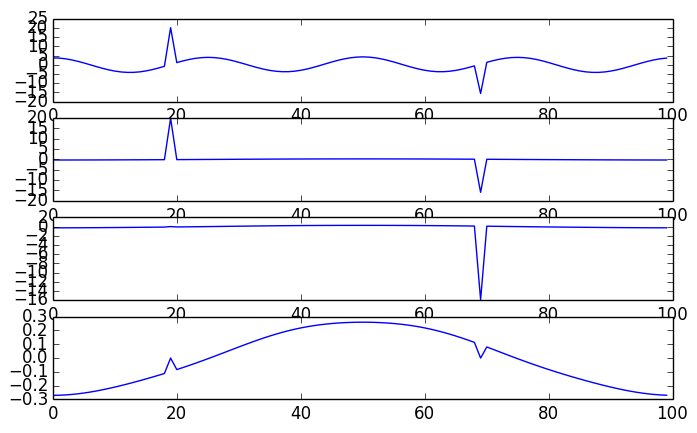

In [23]:
# Matching Pursuit
R = X # remainder
alpha = 4
frame_pckd = zeros(alpha,1)
A = zeros(alpha,1)
for i in 1:4
    if norm(R) == 0
        break;
    end
    bst_prdct = 0; 
    bst_frame = 0;
    for j in 1:M
        flag = 0
        for k in 1:alpha
            if frame_pckd[k] == j
                flag = 1
            end
        end
        if flag == 1
            continue
        end
        # measuring simularity using dot product
        # only cosine wave with no phase shift is applied, we can just consider the real part
        prdct = abs(dot(R,real(D[:,j])))
        #println(prdct)
        if prdct > bst_prdct
            bst_frame = j
            bst_prdct = prdct;
        end
        #println(j, " ", bst_frame)
    end
    A[i] = bst_prdct;
    frame_pckd[i] = bst_frame;
    R = R - (dot(R,real(D[:,bst_frame])))*(real(D[:,bst_frame]))
    subplot(5,1,i+1)
    plot(R)
    #title("Error at iteration ")
end
# first 1 to 100 are natrual basis
# frame 101 is DC 
# frame 102 is 0.01 hz
# frame 105 is 0.04 hz
println("Frame picked: ")
display(frame_pckd)
# display(A)

The above four figures displayed the remainder of the signal after iteration. As we can see, the matching pursuit algorithm picked out two cosine waves first. In the third figure, it correctly removed cosine wave components. Then, it correctly identified the spikes and found right amplitidue for each component as well.

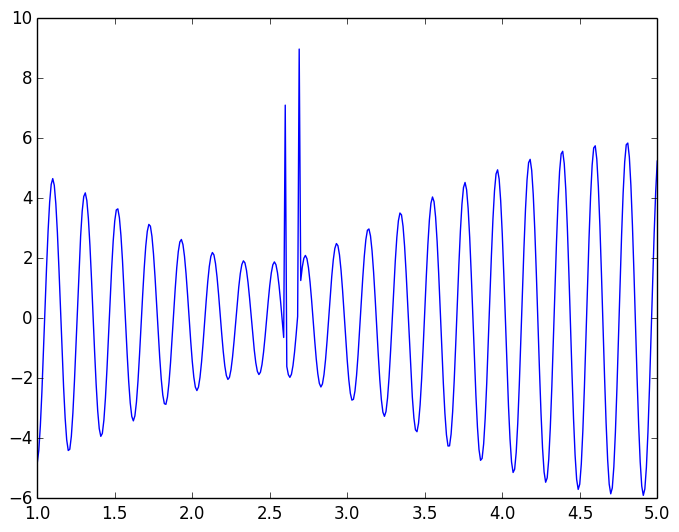

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31654ef50>

In [4]:
# Generate a set of signals composed by twp spikes and two sine waves
# frequency range is 1-5 hz
# spike range 5-10
# amplitude 0.5-5
t = 1:0.01:5
using PyPlot
function generateX()
    f1 = rand()*4+1;
    f2 = rand()*4+1;
    a1 = rand()*4.5+0.5;
    a2 = rand()*4.5+0.5;
    sp1 = rand()*5+5;
    sp2 = rand()*5+5;

    l = length(t)
    s = a1*sin(2*f1*pi*t)+a2*sin(2*f2*pi*t);
    
    loc1 = floor(Int,rand()*l);
    loc2 = floor(Int,rand()*l);
    s[loc1] = s[loc1] + sp1;
    s[loc2] = s[loc2] + sp1; 
    # println("First Frequency chosen is: ", f1)
    # println("Second Frequency chosen is: ", f2)
    return s
end
s = generateX();
plot(t,s)
# display(s)

In this formulation, we pool all the signals $X_i$'s into a big matrix $S \in R^{N \times K}$ and its coefficient $A_i$ into $A \in R^{M \times K}$, where K is number of signals. This is referred as batch method. The representation MSE per signal $X_i$ is defined as $e_i = \| X_i - DA_i \|_2^2$ and the overall MSE as $E = \sum_{i=1}^K e_i^2 = \|S - D{A}\|^2_F$. The optimization can be written in three equivalent ways: $\min_{D,A}\|S - D{A}\|^2_F$ subject to $\|A_i\|_{1} \leq T_0 \ \forall  i$; $\min_{D,A} \sum_i \|A_i\|_1$ subject to $\|S - D{A}\|^2_F \leq \epsilon$ or in the lagrange form $\min_{D,A}\|S - D{A}\|^2_F + \lambda \sum_i\|A_i\|_{1}$

In [ ]:
using JuMP
t = 1:0.01:5
l = length(t)
K = 15 # number of signal
S = zeros(l,K)
for i = 1:K
    S[:,i] = generateX();
end
M = 50 #number of Dictonary entries 
# Initialize the Dictonary entries as random
Dt  = randn(l,M)
T0  = 5;
# given D, calculate A using Lasso
mLasso = Model()
@defVar(mLasso,A[1:M,1:K])
@defVar(mLasso,Z[1:M,1:K] >= 0)
@addConstraint(mLasso, eachSignal[k in 1:K], sum(Z[:,k]) <= T0)
@addConstraint(mLasso, eachAgt[m in 1:M ,k in 1:K], A[m,k] >= -Z[m,k])
@addConstraint(mLasso, eachAls[m in 1:M ,k in 1:K], A[m,k] <= Z[m,k])
@setObjective(mLasso, Min, sum((S - Dt*A).^2))
status = solve(mLasso)
SparseA = getValue(A)
display(SparseA)



In [ ]:
mQCQP = Model()
@defVar(mQCQP, D[1:l,1:M])

@addConstraint(mQCQP, eachDict[m in 1:M], sum(D[:,m].^2) <= 1)
@setObjective(mQCQP, Min, sum((S - D*SparseA).^2))
@time(solve(mQCQP))
Dt = getValue(D)


In [ ]:
# Inspect the learned dictionary in first iteration
Dt = getValue(D)
plot(Dt[:,30],"r")
plot(Dt[:,10],"b")
plot(Dt[:,1],"y")
title("First Iteration")
display(SparseA)

The learned dictionary elements are combination of spikes and sinusoidal waves, which captures the nature of the signal.

In [ ]:
max_itor = 1; 
for itor = 1:max_itor
    # given D, calculate A using Lasso
    mLasso = Model()
    @defVar(mLasso,A[1:M,1:K])
    @defVar(mLasso,Z[1:M,1:K] >= 0)
    @addConstraint(mLasso, eachSignal[k in 1:K], sum(Z[:,k]) <= T0)
    @addConstraint(mLasso, eachAgt[m in 1:M ,k in 1:K], A[m,k] >= -Z[m,k])
    @addConstraint(mLasso, eachAls[m in 1:M ,k in 1:K], A[m,k] <= Z[m,k])
    @setObjective(mLasso, Min, sum((S - Dt*A).^2))
    @time(solve(mLasso))
    SparseA = getValue(A)
    # display(SparseA) 
    # Given A, calculate D
    mQCQP = Model()
    @defVar(mQCQP, D[1:l,1:M])
    @addConstraint(mQCQP, eachDict[m in 1:M], sum(D[:,m].^2) <= 1)
    @setObjective(mQCQP, Min, sum((S - D*SparseA).^2))
    @time(solve(mQCQP))
    Dt = getValue(D)
end


## 4. Results and discussion ##

### Matching  Pursuit (MP)
In solution section, we first examined matching pursuit algorithm on mixture of spike and sinusoidal signals. Matching pursuit aims to find the best matching projections of signal on the the choosen dictionary. This is usually applied when characteristics of the signal is known. Furthermore, since matching pursuit choose the dictionary in a greedy way, it can search through extremely large dictionary fairly quickly.

There are many extension or variant of this algorithm. They either choose a more complicated matching step or better projection step. In escence, it is a trade off between speed and performance. The most used variant is orthogonal matching pursuit (OMP) The main difference from MP is that after every step, all the coefficients extracted so far are updated, by computing the orthogonal projection of the signal onto the set of atoms selected so far. This can lead to better results than standard MP, but requires more computation on each iteration. 

### Dictionary Learning
Next, we examined dictionary learning on a set of randomly generated mixture of spike and sinusoidal signal. The alternating procedure is the key to all dictionary learning.

In the example we examine, the learned dictionary elements after first iteration are shown. The dictionary elements are combination of spikes and sinusoidal waves. We can choose the sparity of solution by choosing the parameter $T_0$. However, we cannot find an extremely sparse solution using this method because the QCQP updating step requires a positive semidefinite matrix $A$. If $A$ is too sparse, $A^2$ usually is not semi-positive definite. 

The method we use here is referred as a batch method. In the optimization, all the signal is pooled together. The batch method will converge in very few iterations, but each iteration take a large amount of time and memory. Most of state of art dictionary learning algorithms are online learning algorithm. Instead of using whole batch of signals, they take one signal at a time. They still apply the same alternating procedure. Usually, each iteration take small amount of time, but they need many iterations to converge to a local minimum. Another benefit of online algorithm is that each intermediate step provides a solution. K-SVD is a very popular state-of-art dictonary learning algorithm.

The OMP approximates the sparse problem $\min_{A} \|X - DA \|_2^2$ subject to $\|A\|_0 \leq T$ while dictionary learning deals with a $\ell_1$ surrogate regulaizer. If dictionary is known, the optimization fomulates as $\min_{A} \|X - DA \|_2^2$ subject to $\|A\|_1 \leq T$. Two methods do not provide the same solution. 

In dictionary learning, choosing number of dictionary elements is very important. One extreme case is using the pool of signal as dictionary elements directly. This result in a one-sparse solution for training data. However, it provides poor predictive power and does not provide sparse solution for other signals. In general, the more dictionary elements are used, the lower the approximation error on training set. On the other hand, using to many dictionary elements tend to overfit the training set and demands large computation resources. In applications, we try out different settings on sparsity level and number of dictionary elements to choose the most satifactory solution.

## 5. Conclusion ##

In this report, we reviewed the sparse coding using off-the-shelf basis system, overcomplete dictionary and dictionary learned from signals. In the dictionary learning algorithm, we formulate the objective function as a quadratic error term and $\ell_1$ regularizer. We applied an alternating update procedures to learn dictionary $D$ and its sparse coefficient $A$. The procedure we applied is a batch algorithm. Some of the state of art algorithm, such as K-SVD, uses a online updating procedure.